# **Anomaly Detection using Zscore**
Implementacao em Python de detecção de anomalias via variação do Zscore. Tradução para Python da implementação do Vini feita no Sheets.

## Referências


* **Documentação Rpy2**: https://stackoverflow.com/questions/51458445/can-you-use-rmagic-rpy2-in-google-colaboratory
* **Blog Anomalia Parte 1**: https://blog.dp6.com.br/t%C3%A9cnicas-de-detec%C3%A7%C3%A3o-de-anomalias-3d9e216bf82e
* **Blog Anomalia Parte 2**: https://blog.dp6.com.br/t%C3%A9cnicas-de-detec%C3%A7%C3%A3o-de-anomalias-parte-ii-99ecb90f93b 

## Setup

Instalação de libraries

* **PyDrive**: conexão Google Drive API
* **Nose**: para teste unitário
* **Matplotlib**: plotting library
* **Numpy**: scientific computing
* **Seaborn**: visualização de dados estatísticos

In [25]:
# Interface de uso do R em Python
!apt-get update
!apt-get install r-base

!pip install -U -q PyDrive
!pip install matplotlib
!pip install numpy

import pandas as pd
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [83.2 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 247 kB in 1s (170 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (3.4.4-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remo

## Autenticação Google Drive

*Importa* todas as funções e variáveis do modulo **os**. Demais são imports específicos dos respectivos módulos.




In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autentica e cria um cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Leitura Arquivo de Entrada

Leitura do arquivo .csv pelo ID do arquivo no Drive. Do dataframe com a base, converte o timestamp para datetime e seta o índice do dataframe como sendo o timestamp.

In [0]:
# Arquivo de entrada
data = drive.CreateFile({'id': '185-pwG_6iSurv0aU2z9_H91MUnfFfOq_'})
data.GetContentFile('raw_data.csv')
df = pd.read_csv('raw_data.csv', usecols=['timestamp', 'count'])
df['timestamp'] = pd.to_datetime(df['timestamp']) # converte coluna timestamp para datetime
df.index = df['timestamp'] # seta df['timestamp'] como indice
del df['timestamp'] # deleta a coluna timestamp

## Tratamento Dados

Cria colunas de data para agrupamento.

In [28]:
df_consolidate = df.reset_index() # Resetar indice do timestamp
df_consolidate['weekday'] = df_consolidate['timestamp'].dt.dayofweek
df_consolidate['day'] = df_consolidate['timestamp'].dt.day
df_consolidate['date'] = pd.to_datetime(df_consolidate['timestamp']).apply(lambda x: x.date())
df_consolidate.info()
df_consolidate.head()
df_consolidate = df_consolidate.rename(index=str, columns={"count":"value"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14398 entries, 0 to 14397
Data columns (total 5 columns):
timestamp    14398 non-null datetime64[ns]
count        14398 non-null float64
weekday      14398 non-null int64
day          14398 non-null int64
date         14398 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 562.5+ KB


Cria dataframe **df_date** com a soma de valor agrupado por dia. Uso o **errors='coerce'** pois o *to_datetime* falha silenciosamente. Assim, se a conversão falha para uma string em particular, então a linha é setada como **NaT**.

Mais detalhes sobre a solução do problema em: https://stackoverflow.com/questions/33365055/attributeerror-can-only-use-dt-accessor-with-datetimelike-values

In [0]:
df_date = df_consolidate.groupby(['date']).agg({"value": "sum"})
#df_date.index = pd.to_datetime(df_date.index)
#df_date.info()
df_date = df_date.reset_index()
df_date['date'] = pd.to_datetime(df_date['date'], errors='coerce')

Cria dataframe **df_week** com a soma de valor agrupado por dia da semana.

In [30]:
#df_week = df_date.groupby(df_date['date'].dt.weekday_name).mean()
df_week = df_date.groupby(df_date['date'].dt.weekday).mean()
df_week = df_week.reset_index()
df_week['avg'] = df_week['value']
df_week['weekday'] = df_week['date']
df_week = df_week.drop(columns=['value','date'])
df_week.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
avg        7 non-null float64
weekday    7 non-null int64
dtypes: float64(1), int64(1)
memory usage: 192.0 bytes


Cria dataframe **df_lastDays** com a soma de valor dos últimos 7 dias.

In [0]:
df_lastDays = df_consolidate.groupby(['date', 'weekday']).agg({"value": "sum"})
df_lastDays = df_lastDays.reset_index()
df_lastDays = df_lastDays.sort_values(by=['date'],ascending=False)
df_lastDays = df_lastDays.head(7).sort_values(by=['weekday'],ascending=True)
df_lastDays['lastDay'] = df_lastDays['value']
df_lastDays = df_lastDays.drop(columns=['date','value'])

Cria dataframe **df_desvio** com o cálculo do desvio padrão por dia da semana do período analisado.

* **agg()** agrega a operação especificada para a coluna agrupada no dataframe
* **ddof**: delta degrees of freedom (default é 0). Significa que na fórmula do desvio padrão dividimos por N - 0 = N. Se selecionar uma amostra aleatória de N elementos de uma distribuição maior e calcular a variança, a divisão por N pode levar a um resultado subestimado. Assim, usamos os graus de liberdade para um número menor que N (N - ddof).

> Mais detalhes sobre ddof em: https://stackoverflow.com/questions/27600207/why-does-numpy-std-give-a-different-result-to-matlab-std/27601280

In [0]:
df_desvio = df_consolidate.groupby(['weekday']).agg(np.std, ddof=0)
df_desvio = df_desvio.reset_index()
df_desvio['desvio'] = df_desvio['value']
df_desvio = df_desvio.drop(columns=['timestamp','day','date','value'])

Agrupa todos os dados calculados anteriormente no datragrame **df_total**.

In [0]:
df_total = pd.merge(df_week, df_lastDays, how='left', on='weekday')
df_total = pd.merge(df_total, df_desvio, how='left', on='weekday')

df_total['zscore'] = (df_total['lastDay'] - df_total['avg']) / df_total['desvio']

## Visualização dos Dados

Volume por timestamp

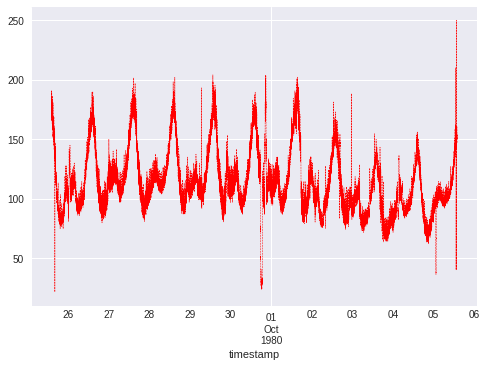

In [34]:
ax = plt.subplots()
df['count'].plot(color = 'red', linestyle='dashed', linewidth = 0.5, x=ax)

Volume diário das datas

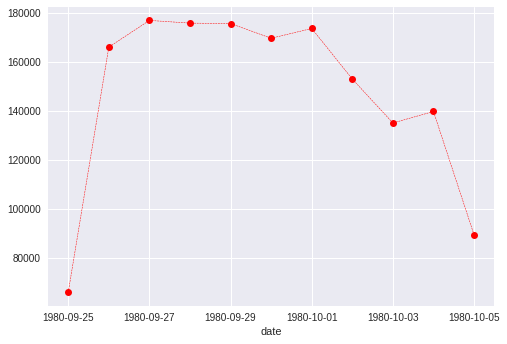

In [35]:
df_date = df_consolidate.groupby(['date']).agg({"value": "sum"})
#df_date.index = df_date['date']
#del(df_date['date'])

df_date['value'].plot(color = 'red', linestyle='--', marker='o', linewidth = 0.5, x=ax)

Volume Últimos 7 dias e Z-Score

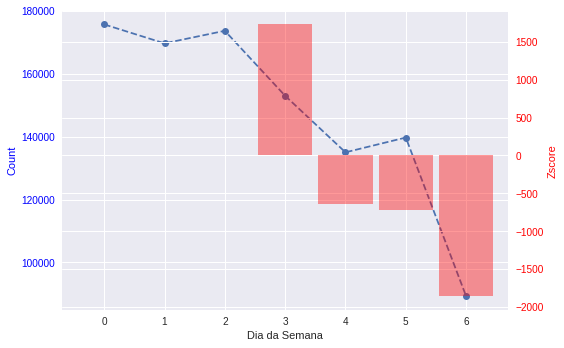

In [36]:
fig, ax1 = plt.subplots()
width = 0.90 # width of a bar

ax1.plot(df_total['weekday'], df_total['lastDay'], linestyle='--', marker='o')
ax1.set_xlabel('Dia da Semana')
ax1.set_ylabel('Count', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()

ax2 = df_total['zscore'].plot(kind='bar', width = width, x=ax1, color='r', alpha=0.4)
ax2.set_ylabel('Zscore', color='r')
ax2.tick_params('y', colors='r')

fig = plt.gcf()
plt.show()


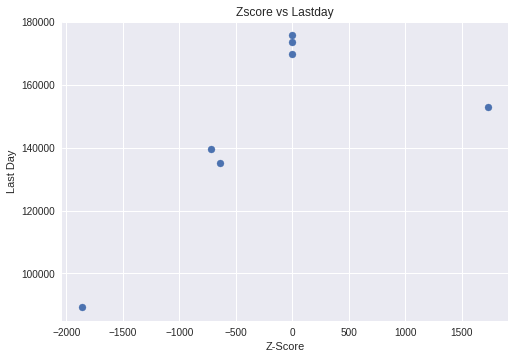

In [37]:


plt.scatter(df_total['zscore'], df_total['lastDay'])
plt.title('Zscore vs Lastday')
plt.xlabel("Z-Score")
plt.ylabel("Last Day")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

#label_point(df_total['zscore'], df_total['lastDay'], df_total['weekday'], plt.gca())

plt.show()


# Modified Z-Score

In [0]:
import scipy.stats as stats
import matplotlib.pyplot as plt   
import numpy as np
import pylab as pl
import pandas as pd


from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

## Máximo Z-score para cada tamanho da amostra

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


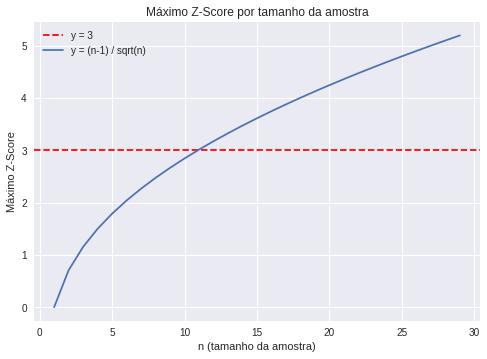

In [39]:
## Create functions and set domain length
x = np.arange(0, 30, 1)
y = (x-1)/np.sqrt(x)
dy = 3*x

## Plot functions and a point where they intersect
plt.axhline(3.0, color='r', linestyle='--')
plt.plot(x, y)


plt.title('Máximo Z-Score por tamanho da amostra')
plt.xlabel('n (tamanho da amostra)')
plt.ylabel('Máximo Z-Score')
plt.grid(True)
plt.legend(['y = 3', 'y = (n-1) / sqrt(n)'], loc='upper left')



## Comparativo Z-score e Z-score Modificado

### Cálculo Z-score

In [40]:
import numpy as np
import pandas as pd

# Base de dados
xi = [3245, 3475, 3723, 3772, 3836, 3967, 4197, 4047, 4169, 4225, 4787, 4008, 3567, 4356]

# Base com outlier
xy = [6798, 3475, 3723, 3772, 3836, 3967, 4197, 4047, 4169, 4225, 4787, 4008, 3567, 4356]

# Média
xi_mean = np.mean(xi)
xy_mean = np.mean(xy)

# Desvio Padrão
xi_sd = np.std(xi, ddof = 1)
xy_sd = np.std(xy, ddof = 1)

# Z-score
z_score_i = (xi - xi_mean)/xi_sd
z_score_y = (xy - xy_mean)/xy_sd

df = pd.DataFrame({'Base (sem outlier)':xi, 'Z-score (sem outlier)':z_score_i,
                   'Base (com outlier)': xy, 'Z-score (com outlier)': z_score_y})
df.round(2)
cols = ['Base (sem outlier)','Z-score (sem outlier)','Base (com outlier)', 'Z-score (com outlier)']
df = df[cols]
df

,Base (sem outlier),Z-score (sem outlier),Base (com outlier),Z-score (com outlier)
0,3245,-1.798239,6798,3.164145
1,3475,-1.215945,3475,-0.897170
2,3723,-0.588080,3723,-0.594068
3,3772,-0.464027,3772,-0.534181
4,3836,-0.301997,3836,-0.455962
5,3967,0.029657,3967,-0.295856
6,4197,0.611951,4197,-0.014753
7,4047,0.232194,4047,-0.198081
8,4169,0.541063,4169,-0.048975
9,4225,0.682839,4225,0.019468


### Verificação distribuição normal

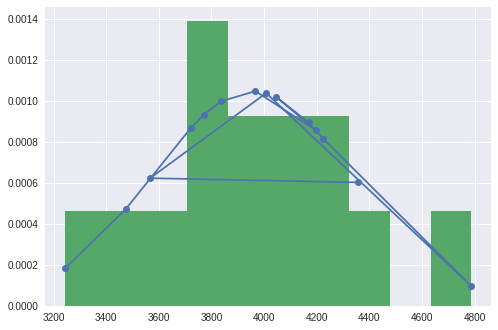

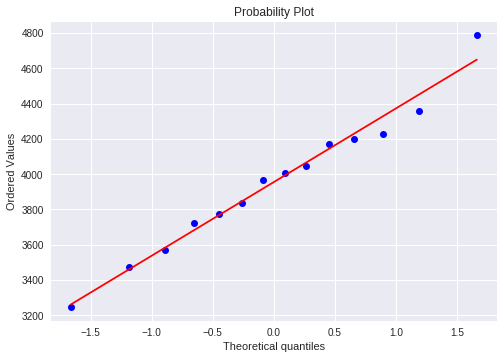

In [41]:
import scipy.stats as stats
import matplotlib.pyplot as plt   
import numpy as np
import pylab as pl
import pandas as pd


from numpy.random import seed
from numpy.random import randn
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

# Base de dados
xi = [3245, 3475, 3723, 3772, 3836, 3967, 4197, 4047, 4169, 4225, 4787, 4008, 3567, 4356]


fit = stats.norm.pdf(xi, np.mean(xi), np.std(xi))
pl.plot(xi, fit,'-o')
pl.hist(xi, normed=True) # plot do histograma dos dados

pl.show()

# Plot da distribuição normal
stats.probplot(xi, dist="norm", plot=pl)
plt.show()

